# Putting it all together : photonic systems

In this notebook, we will :

    1) Use zeropdk to create GDS geometries;
    2) Use parallel MEEP to visualize them and efficiently simulate their S-parameters to obtain compact models;
    3) Network many of these components together to overall circuit behaviour with Photontorch
    
In particular, we will simulate a multiring filter. Because FDTD simulations of resonant structures take a long time, we will model the rings as networks of bends and couplers :

!['multirings'](images/multirings.png)

Also, we will take very tight rings (bend radius of a few microns), which will require us to actually model the bends instead of simply using a "straight" waveguide for the rings.

# Defining geometries

From the block diagram, there are three topologies we will need to model :

    1) Quarter ring bends (2-port network)
    2) Straight-bend coupling (4-port network)
    3) Bend-bend coupling (4-port network)
    
The straight waveguides will simply be modeled as lossless phase accumulation.

## Layer definition

I define some layers :

In [1]:
import pya
import numpy as np

COMP_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE1 = pya.LayerInfo(10, 0)
MEEP_SOURCE2 = pya.LayerInfo(11, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)
MEEP_PORT3 = pya.LayerInfo(22, 0)
MEEP_PORT4 = pya.LayerInfo(23, 0)

## Quarter ring bends

### Definition

In [2]:
ring_radius = 5 # um
ring_width = 0.5 # um

In [3]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box

filename = 'bend_zeropdk.gds'

# Clean existing file
!rm {filename}

# Layout
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# draw simulation region
layout_box(TOP, COMP_CELL, - 0.5*ring_radius*ex - 1.5*ring_radius*ey, 1.5*ring_radius*ex + 0.5*ring_radius*ey, ex)

# draw bend
# layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)
# Sadly, layout_arc does not get imported nicely by meep. So here I changed it to a list of points along the circle
# Create semicircle points
bend_points = []
for theta in np.linspace(0, np.pi/2,100):
    point_x = ring_radius*np.sin(theta)
    point_y = -1*(ring_radius - ring_radius*np.cos(theta))
    bend_points.append(point_x*ex + point_y*ey)
layout_waveguide(TOP, Si, bend_points, ring_width)

# Extend the bend to avoid discontinuities
#layout_waveguide(TOP, Si, [-0.5*ring_radius*ex, 2*ring_radius*ex], ring_width)
layout_waveguide(TOP, Si, [0*ex, - 0.5*ring_radius*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, -1.5*ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width*4
layout_path(TOP, MEEP_SOURCE1, [-port_size/2*ey - 0.2*ex, port_size/2*ey - 0.2*ex], 0)
layout_path(TOP, MEEP_PORT1, [-port_size/2*ey, port_size/2*ey], 0)
layout_path(TOP, MEEP_PORT2, [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex , -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)
#layout_path(TOP, MEEP_PORT2, [ring_radius*ex - port_size/2*ey , ring_radius*ex + port_size/2*ey], 0)

layout.write(filename)
del layout, TOP

It takes a few seconds to generate the file, so wait before loading it.

### Visualization and simulation

You can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating :

In [4]:
# %%writefile meep_bend.py 
# uncomment to save to script

# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

ring_radius = 5 # um
ring_width = 0.5 # um

res = 128        # pixels/μm

gdsII_file = 'bend_zeropdk.gds'
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

dpml = 1
cell_thickness = dpml+t_oxide+t_Si+t_SiO2+dpml
si_zmin = 0

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file

# Clear MEEP memory (otherwise will just add stuff over old stuff)
try: del si_layer
except NameError: x = None
    
# Manual fix
# geometry = []
# geometry.append(mp.Cylinder(material=silicon, center=mp.Vector3(0,-1*ring_radius,0), radius=ring_radius + ring_width/2, height=0))
# geometry.append(mp.Cylinder(material=oxide, center=mp.Vector3(0,-1*ring_radius,0), radius=ring_radius - ring_width/2, height=0))
# geometry.append(mp.Block(material=oxide, center=mp.Vector3(-0.5*ring_radius,0,0), size=mp.Vector3(ring_radius,2*ring_radius,0)))
# geometry.append(mp.Block(material=oxide, center=mp.Vector3(ring_radius,-1.5*ring_radius,0), size=mp.Vector3(2*ring_radius,ring_radius,0)))
    
si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

# # Later objects get priority : fix
final_geometry = []
# for fix in geometry:
#     final_geometry.append(fix)
for fix in si_layer:
    final_geometry.append(fix)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, 20, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, 21, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.EVEN_Y+mp.ODD_Z,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=final_geometry,
                    geometry_center=mp.Vector3(ring_radius/2, -ring_radius/2))

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))

Using MPI version 3.1, 1 processes


In [5]:
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000673056 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 128
     prism, center = (3.17815,-1.82185,0)
          height 0, axis (0,0,1), 192 vertices:
          (4.75,-5.002,0)
          (4.749,-4.925,0)
          (4.748,-4.849,0)
          (4.745,-4.774,0)
          (4.735,-4.624,0)
          (4.728,-4.548,0)
          (4.721,-4.474,0)
          (4.712,-4.399,0)
          (4.702,-4.324,0)
          (4.69,-4.249,0)
          (4.678,-4.175,0)
          (4.664,-4.101,0)
          (4.649,-4.027,0)
          (4.633,-3.954,0)
          (4.616,-3.88,0)
          (4.598,-3.807,0)
          (4.578,-3.734,0)
          (4.558,-3.662,0)
          (4.536,-3.59,0)
          (4.513,-3.518,0)
          (4.489,-3.446,0)
          (4.464,-3.375,0)
          (4.41,-3.235,0)
          (4.381,-3.165,0)
          (4.352,-3.096,0)
          (4.321,-3.027,0)
          (4.289,-2.958,0)
          (4.256,-2.89

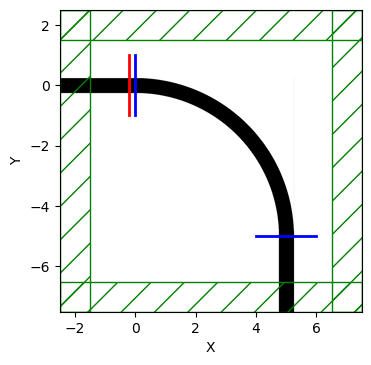

In [6]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Looks pretty good. Simulations at the high enough resolution required to avoid spurious reflections in the bend are very slow! This can be sped up quite a bit by running the code in parallel from the terminal. so let's put the meep code into a script and run it in parallel. 

Save the code in a script. You could copy past, or use Jupyter magics such as `%%writefile meep_bend.py` at the top of the relevant cells to dump the cell text into a file (the second argument is the file name). Then add what's missing from it with the `-a` flag as in the following :

In [7]:
%%writefile -a meep_bend.py

# Setup and run the simulation
#f = plt.figure(dpi=100)
#animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
#sim.run(mp.at_every(1,animate),until_after_sources=100)
sim.run(until_after_sources=100)
#plt.close()

# Do the analysis we want
# S parameters
# I am computing 3 bands to choose the right coefficients
print(sim.get_eigenmode_coefficients(mode1, [1,2,3], eig_parity=mp.NO_PARITY))
print(sim.get_eigenmode_coefficients(mode2, [1,2,3], eig_parity=mp.NO_PARITY))

# Save a video
#filename = 'media/bend.mp4'
#animate.to_mp4(10,filename)

Appending to meep_bend.py


The, from the terminal, run parallel with all your cores (here I have 4) :

`
conda activate all_tools
mpirun -np 4 python meep_bend.py
`

Look at the video it makes as a sanity check :

In [11]:
from IPython.display import Video
filename = 'media/bend.mp4'
Video(filename)

Now let's look at the mode monitor results from the run.

TODO! Issues with results? Need to dig into `get_eigenmode_coefficients` and `add_mode_monitor` more...

## Ring-waveguide coupling

TO FINISH

### Definition

(There is a cleaner way to do this by putting the quarter ring in a class object, using rotations, etc.)

In [4]:
ring_radius = 5 # um
ring_width = 0.5 # um
coupler_gap = 0.2 # um

In [5]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box, layout_rectangle

filename = 'coupler_zeropdk.gds'

# Clean existing file
!rm {filename}

# Layout
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# draw simulation region
layout_box(TOP, COMP_CELL, - 0.5*ring_radius*ex - 1.5*ring_radius*ey, 1.8*ring_radius*ex + 0.8*ring_radius*ey, ex)

# draw bend
bend_points = []
for theta in np.linspace(0, np.pi/2,100):
    point_x = ring_radius*np.sin(theta)
    point_y = -1*(ring_radius - ring_radius*np.cos(theta))
    bend_points.append(point_x*ex + point_y*ey)
layout_waveguide(TOP, Si, bend_points, ring_width)

# Extend the bend to avoid discontinuities
#layout_waveguide(TOP, Si, [-0.5*ring_radius*ex, 2*ring_radius*ex], ring_width)
layout_waveguide(TOP, Si, [0*ex, - 0.5*ring_radius*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, -1.5*ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width*4
layout_path(TOP, MEEP_SOURCE1, [-port_size/2*ey - 0.2*ex, port_size/2*ey - 0.2*ex], 0)
layout_path(TOP, MEEP_PORT1, [-port_size/2*ey, port_size/2*ey], 0)
layout_path(TOP, MEEP_PORT2, [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex , -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)
#layout_path(TOP, MEEP_PORT2, [ring_radius*ex - port_size/2*ey , ring_radius*ex + port_size/2*ey], 0)


# Add straight waveguide
theta = np.pi/4
gap_point_x = ring_radius*np.sin(theta) + (coupler_gap + ring_width)*np.sin(theta)
gap_point_y = -1*(ring_radius - ring_radius*np.cos(theta)) + (coupler_gap + ring_width)*np.cos(theta)
layout_rectangle(TOP, Si, center=gap_point_x*ex + gap_point_y*ey, width=3*ring_radius, height=ring_width, ex=np.sin(theta)*ex - np.cos(theta)*ey)

# Add its ports
port_size = ring_width*4
port3_center = gap_point_x*ex + gap_point_y*ey - 0.8*(ring_radius*np.sin(theta)*ex - ring_radius*np.cos(theta)*ey)
port4_center = gap_point_x*ex + gap_point_y*ey + 0.8*(ring_radius*np.sin(theta)*ex - ring_radius*np.cos(theta)*ey)
layout_path(TOP, MEEP_PORT3, [port3_center - port_size/2*(np.sin(theta)*ex + np.cos(theta)*ey), port3_center + port_size/2*(np.sin(theta)*ex + np.cos(theta)*ey)], 0)
layout_path(TOP, MEEP_PORT4, [port4_center - port_size/2*(np.sin(theta)*ex + np.cos(theta)*ey) , port4_center + port_size/2*(np.sin(theta)*ex + np.cos(theta)*ey)], 0)

layout.write(filename)
del layout, TOP

In [9]:
%%writefile coupler_meep.py

# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

ring_radius = 5 # um
ring_width = 0.5 # um
coupler_gap = 0.2 # um

res = 128        # pixels/μm

gdsII_file = 'coupler_zeropdk.gds'
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21
PORT3_LAYER = 22
PORT4_LAYER = 23

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

dpml = 1
cell_thickness = dpml+t_oxide+t_Si+t_SiO2+dpml
si_zmin = 0

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file

# Clear MEEP memory (otherwise will just add stuff over old stuff)
try: del si_layer
except NameError: x = None
    
# Manual fix
# geometry = []
# geometry.append(mp.Cylinder(material=silicon, center=mp.Vector3(0,-1*ring_radius,0), radius=ring_radius + ring_width/2, height=0))
# geometry.append(mp.Cylinder(material=oxide, center=mp.Vector3(0,-1*ring_radius,0), radius=ring_radius - ring_width/2, height=0))
# geometry.append(mp.Block(material=oxide, center=mp.Vector3(-0.5*ring_radius,0,0), size=mp.Vector3(ring_radius,2*ring_radius,0)))
# geometry.append(mp.Block(material=oxide, center=mp.Vector3(ring_radius,-1.5*ring_radius,0), size=mp.Vector3(2*ring_radius,ring_radius,0)))
    
si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

# # Later objects get priority : fix
final_geometry = []
# for fix in geometry:
#     final_geometry.append(fix)
for fix in si_layer:
    final_geometry.append(fix)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, 20, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, 21, si_zmin, si_zmax)
p3 = mp.GDSII_vol(gdsII_file, 22, si_zmin, si_zmax)
p4 = mp.GDSII_vol(gdsII_file, 23, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.EVEN_Y+mp.ODD_Z,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=final_geometry,
                    geometry_center=mp.Vector3(ring_radius/2, -ring_radius/2))

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
#mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
#mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))
#mode3 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p3))
#mode4 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p4))

Writing coupler_meep.py


In [10]:
%%writefile -a coupler_meep.py

# Setup and run the simulation
f = plt.figure(dpi=100)
animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
sim.run(mp.at_every(1,animate),until_after_sources=100)
#sim.run(until_after_sources=100)
plt.close()

# Do the analysis we want
# S parameters
print(sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY))
print(sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY))

# Save a video
filename = 'media/coupler.mp4'
animate.to_mp4(10,filename)

Appending to coupler_meep.py


In [7]:
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000715017 s
Working in 2D dimensions.
Computational cell is 11.5 x 11.5 x 0 with resolution 128
     prism, center = (3.17815,-1.82185,0)
          height 0, axis (0,0,1), 192 vertices:
          (4.75,-5.002,0)
          (4.749,-4.925,0)
          (4.748,-4.849,0)
          (4.745,-4.774,0)
          (4.735,-4.624,0)
          (4.728,-4.548,0)
          (4.721,-4.474,0)
          (4.712,-4.399,0)
          (4.702,-4.324,0)
          (4.69,-4.249,0)
          (4.678,-4.175,0)
          (4.664,-4.101,0)
          (4.649,-4.027,0)
          (4.633,-3.954,0)
          (4.616,-3.88,0)
          (4.598,-3.807,0)
          (4.578,-3.734,0)
          (4.558,-3.662,0)
          (4.536,-3.59,0)
          (4.513,-3.518,0)
          (4.489,-3.446,0)
          (4.464,-3.375,0)
          (4.41,-3.235,0)
          (4.381,-3.165,0)
          (4.352,-3.096,0)
          (4.321,-3.027,0)
          (4.289,-2.958,0)
          (4.256,-

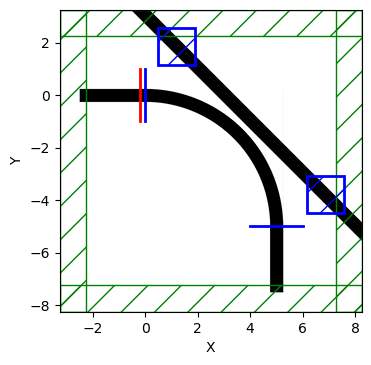

In [8]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()